In [1]:
from google.colab import drive
import pandas as pd

In [5]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to your dataset in Google Drive
file_path1 = '/content/drive/My Drive/Colab Notebooks/TEST/cleandf (1).csv'

# Read the dataset into a DataFrame
df = pd.read_csv(file_path1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **A. FORMATTING**
We will divide our dataset by rule 80:20, Training include Train and Validation, and Testing

In [6]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers

In [7]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['User_id', 'ISBN', 'Tittle', 'Author', 'Publisher']
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Normalize numerical features
scaler = MinMaxScaler()
df['Rating'] = scaler.fit_transform(df['Rating'].values.reshape(-1, 1))

# Display the first few rows of the preprocessed dataset
print(df.head())

   User_id   ISBN  Rating  Age  Tittle  Author  Year-Of-Publication  Publisher
0    91362  45921     0.0   76   67829   61682                 2002       1388
1      711  45921     0.5   23   67829   61682                 2002       1388
2     2040  45921     0.0   34   67829   61682                 2002       1388
3     2721  45921     0.5    2   67829   61682                 2002       1388
4     3202  45921     0.9   58   67829   61682                 2002       1388


# **B. SPLITTING DATA (80:20)**

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# Define features and target variable
X = df[['User_id', 'ISBN', 'Rating', 'Age', 'Tittle', 'Author', 'Year-Of-Publication', 'Publisher']]
y = df['Rating']

# Split the data into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training data into training and validation sets (80:20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Display the shapes of the split datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (659926, 8) (659926,)
Validation set shape: (164982, 8) (164982,)
Testing set shape: (206228, 8) (206228,)


In [10]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import regularizers

In [11]:
# Define embedding size
embedding_size = 50

# Compute the number of unique books and users
num_books = df['ISBN'].nunique()
num_users = df['User_id'].nunique()

# Input layers
user_id_input = tf.keras.layers.Input(shape=(1,), name='user_id')
isbn_input = tf.keras.layers.Input(shape=(1,), name='isbn')

# Embedding layers
user_embedding = tf.keras.layers.Embedding(input_dim=num_users, output_dim=embedding_size, input_length=1, name='user_embedding')(user_id_input)
isbn_embedding = tf.keras.layers.Embedding(input_dim=num_books, output_dim=embedding_size, input_length=1, name='isbn_embedding')(isbn_input)

# Flatten embeddings
user_flat = tf.keras.layers.Flatten()(user_embedding)
isbn_flat = tf.keras.layers.Flatten()(isbn_embedding)

# Concatenate flattened embeddings
concatenated_embeddings = tf.keras.layers.Concatenate()([user_flat, isbn_flat])

# Add dropout layer
dropout = tf.keras.layers.Dropout(0.2)(concatenated_embeddings)
dropout1 = tf.keras.layers.Dropout(0.2)(concatenated_embeddings)

# Add additional dense layers with different activations
dense_1 = tf.keras.layers.Dense(512, activation='relu')(dropout)
dense_2 = tf.keras.layers.Dense(64, activation='relu')(dense_1)
dense_3 = tf.keras.layers.Dense(512, activation='relu')(dropout1)
dense_4 = tf.keras.layers.Dense(128, activation='relu')(dense_3)

# Output layer
output = tf.keras.layers.Dense(1, activation='linear')(dense_4)

# Create model
model = tf.keras.models.Model(inputs=[user_id_input, isbn_input], outputs=output)

# Define optimizer with learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model with MSE loss and accuracy metric
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

# Train the model for more epochs
history = model.fit([X_train['User_id'], X_train['ISBN']], y_train, validation_data=([X_val['User_id'], X_val['ISBN']], y_val), epochs=20, batch_size=64)


Epoch 1/20
10312/10312 [==============================] - 93s 9ms/step - loss: 0.1179 - accuracy: 0.6228 - val_loss: 0.1136 - val_accuracy: 0.6305
Epoch 2/20
10312/10312 [==============================] - 85s 8ms/step - loss: 0.0901 - accuracy: 0.6334 - val_loss: 0.1263 - val_accuracy: 0.5966
Epoch 3/20
10312/10312 [==============================] - 85s 8ms/step - loss: 0.0745 - accuracy: 0.6460 - val_loss: 0.1332 - val_accuracy: 0.5761
Epoch 4/20
10312/10312 [==============================] - 86s 8ms/step - loss: 0.0640 - accuracy: 0.6543 - val_loss: 0.1346 - val_accuracy: 0.5796
Epoch 5/20
10312/10312 [==============================] - 83s 8ms/step - loss: 0.0558 - accuracy: 0.6610 - val_loss: 0.1403 - val_accuracy: 0.5680
Epoch 6/20
10312/10312 [==============================] - 84s 8ms/step - loss: 0.0493 - accuracy: 0.6665 - val_loss: 0.1455 - val_accuracy: 0.5639
Epoch 7/20
10312/10312 [==============================] - 86s 8ms/step - loss: 0.0439 - accuracy: 0.6710 - val_loss: 0

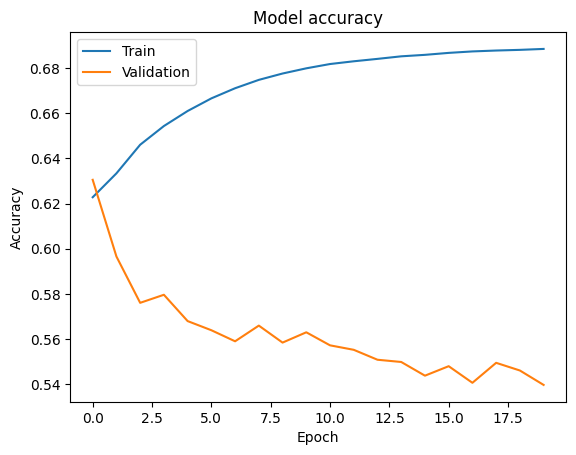

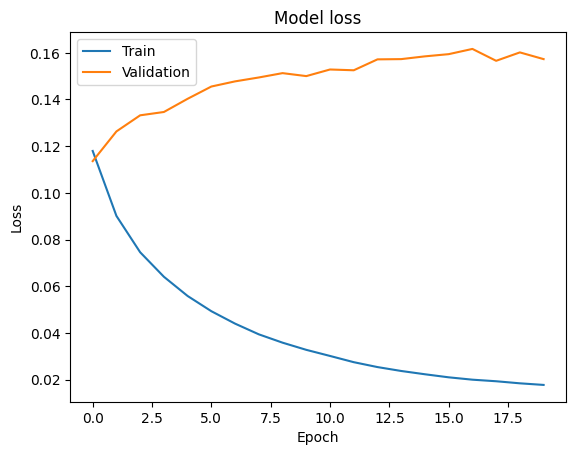

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [13]:
import numpy as np
import pandas as pd

In [24]:
def get_top_recommendations(user_id, num_books, model, df, top_n=10):
    # Create arrays for user_id and all book ISBNs
    user_ids = np.array([user_id] * num_books)
    isbn_ids = np.arange(num_books)

    # Predict ratings for all books for the given user
    ratings = model.predict([user_ids, isbn_ids]).flatten()

    # Get the top N recommended book indices
    top_recommendations = np.argsort(ratings)[-top_n:][::-1]

    # Get the corresponding ISBNs
    top_isbns = df.iloc[top_recommendations]['ISBN'].values

    # Map the ISBNs to unique book titles
    top_titles = df[df['ISBN'].isin(top_isbns)].drop_duplicates(subset=['ISBN'])['Tittle'].values

    return top_titles

# Example usage:
user_id = 123  # Example user ID
num_books = df['ISBN'].nunique()  # Assuming df contains your book data
top_titles = get_top_recommendations(user_id, num_books, model, df, top_n=10)

# Print the top recommended book titles
for title in top_titles:
    print(title)

8443/8443 [==============================] - 14s 2ms/step
17513
94019
32295
139677
209209
43227
176554
138603
30757
172588


In [38]:
def get_top_recommendations(user_id, num_books, model, df, top_n=10):
    # Create arrays for user_id and all book ISBNs

    user_ids = np.array([user_id] * num_books)
    isbn_ids = np.arange(num_books)

    # Predict ratings for all books for the given user
    ratings = model.predict([user_ids, isbn_ids]).flatten()

    # Get the top N recommended book indices
    top_recommendations = np.argsort(ratings)[-top_n:][::-1]

    # Get the corresponding ISBNs
    top_isbns = df.iloc[top_recommendations]['ISBN'].values

    # Map the ISBNs to unique book titles
    top_titles = df[df['ISBN'].isin(top_isbns)].drop_duplicates(subset=['ISBN'])['Tittle'].values

    return top_titles


# Example usage:
user_id = df['User_id'].sample(1).iloc[0]
num_books = df['ISBN'].nunique()  # Assuming df contains your book data
top_titles = get_top_recommendations(user_id, num_books, model, df, top_n=10)
# Inverse transform the numerical book titles to their original categorical values
top_titles = label_encoders['Tittle'].inverse_transform(top_titles)
# Print the top recommended book titles
for title in top_titles:
    print(title)

8443/8443 [==============================] - 14s 2ms/step
Attack Of The Deranged Mutant Killer Snow Goons
The Lovely Bones: A Novel
Smilla's Sense of Snow
A Day Late and a Dollar Short
Galileo's Daughter: A Historical Memoir of Science, Faith, and Love
The Cider House Rules
The Subtle Knife (His Dark Materials, Book 2)
Until Dark
The HEALING OF AMERICA
No Way Out


In [36]:
model.save("my_model.h5")

In [37]:
# Load the saved Keras model
loaded_model = tf.keras.models.load_model('my_model.h5')

# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('my_model.tflite', 'wb') as f:
    f.write(tflite_model)